In [1]:
import pandas as pd
import numpy as np

## Step 1: Select Control Stores 

In [2]:
QVI_data = pd.read_csv('QVI_data.csv')

In [3]:
QVI_data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [4]:
QVI_data['DATE'] = pd.to_datetime(QVI_data['DATE'])

In [5]:
Pre_Trial = QVI_data[(QVI_data['DATE'] < '2019-02-01')]

In [6]:
Pre_Trial['MONTH/YEAR'] = Pre_Trial['DATE'].dt.to_period('M')

<ipython-input-6-818493148bcc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pre_Trial['MONTH/YEAR'] = Pre_Trial['DATE'].dt.to_period('M')


In [7]:
# Calculate the total sales and total transactions for each stores
Pre_Trial_sum = Pre_Trial.groupby(by = ['STORE_NBR','MONTH/YEAR']).sum().reset_index()
Pre_Trial_count = Pre_Trial.groupby(by = ['STORE_NBR','MONTH/YEAR']).count().reset_index()

In [8]:
Pre_Trial_info = pd.merge(Pre_Trial_sum[['MONTH/YEAR','STORE_NBR','TOT_SALES','PROD_QTY']],Pre_Trial_count[['MONTH/YEAR','STORE_NBR','PREMIUM_CUSTOMER']], how = 'inner')
Pre_Trial_info.rename(columns= {'PREMIUM_CUSTOMER':'TOT_TRANSACTION'}, inplace= True)

In [9]:
Pre_Trial_info.head()

,MONTH/YEAR,STORE_NBR,TOT_SALES,PROD_QTY,TOT_TRANSACTION
0,2018-07,1,206.9,62,52
1,2018-08,1,176.1,54,43
2,2018-09,1,278.8,75,62
3,2018-10,1,188.1,58,45
4,2018-11,1,192.6,57,47


In [10]:
#Calculate the total customers for each store, and merge the table with the info table
Pre_Trial_info = pd.merge(Pre_Trial.groupby(by = ['STORE_NBR','MONTH/YEAR']).nunique()['LYLTY_CARD_NBR'].reset_index(), Pre_Trial_info, how = 'inner')

In [11]:
Pre_Trial_info.rename(columns={'LYLTY_CARD_NBR':'TOT_CUSTOMER'}, inplace = True)

In [12]:
Pre_Trial_info['AVG_TRANS_per_CUSTOMER'] = Pre_Trial_info['TOT_TRANSACTION']/Pre_Trial_info['TOT_CUSTOMER']


In [13]:
#drop the stores that doesn't operate during the entire pre-trial period
def is_full_pre_trial(s):
    return Pre_Trial_info[Pre_Trial_info['STORE_NBR'] == s]['MONTH/YEAR'].nunique() == Pre_Trial_info['MONTH/YEAR'].nunique()

Pre_Trial_info.drop(index = Pre_Trial_info[Pre_Trial_info['STORE_NBR'].apply(is_full_pre_trial)== False].index, inplace = True)


In [14]:
Pre_Trial_info.head()

,STORE_NBR,MONTH/YEAR,TOT_CUSTOMER,TOT_SALES,PROD_QTY,TOT_TRANSACTION,AVG_TRANS_per_CUSTOMER
0,1,2018-07,49,206.9,62,52,1.061224
1,1,2018-08,42,176.1,54,43,1.023810
2,1,2018-09,59,278.8,75,62,1.050847
3,1,2018-10,44,188.1,58,45,1.022727
4,1,2018-11,46,192.6,57,47,1.021739


In [15]:
#Create the data frame that shows how each stores is correlated to the trial stores
Pre_Trial_comparison = pd.DataFrame()

In [16]:
Pre_Trial_comparison['STORE_NBR'] = Pre_Trial_info['STORE_NBR'].unique()

In [17]:
#define a metric to calculate the correlation
def mean_dist(tri_str_num,control_str_num,FEATURE):
    mag_difference = 0
    for month in Pre_Trial_info['MONTH/YEAR'].unique():
        mag_difference += abs(Pre_Trial_info[(Pre_Trial_info['STORE_NBR'] == tri_str_num) & (Pre_Trial_info['MONTH/YEAR'] == month)][FEATURE].item() -
                            Pre_Trial_info[(Pre_Trial_info['STORE_NBR'] == control_str_num) & (Pre_Trial_info['MONTH/YEAR'] == month)][FEATURE].item())
    return (mag_difference/Pre_Trial_info['MONTH/YEAR'].nunique())

In [18]:
control_store_NBR = [77,86,88]
Features = ['TOT_CUSTOMER','TOT_SALES','AVG_TRANS_per_CUSTOMER']

In [19]:
for feature in Features:
    for num in control_store_NBR:
        Pre_Trial_comparison['mean_dif_'+str(num)+'_'+feature] = Pre_Trial_comparison['STORE_NBR'].apply(mean_dist,control_str_num = num, FEATURE = feature)

In [20]:
#standaardise the data for better comparison (1 = most related, 0 = not related)
comparison_col = Pre_Trial_comparison.columns
comparison_col = comparison_col.drop('STORE_NBR')

for col in comparison_col:
    Pre_Trial_comparison[col] = 1-(Pre_Trial_comparison[col]/Pre_Trial_comparison[col].max())

In [21]:
#take an average of the scores for each store
# weight heavier for total sales and total customers
for num in control_store_NBR:
    Pre_Trial_comparison['avg_'+str(num)] = 0.4*Pre_Trial_comparison['mean_dif_'+str(num)+'_'+'TOT_CUSTOMER']+ 0.4*Pre_Trial_comparison['mean_dif_'+str(num)+'_'+'TOT_SALES']+0.2*Pre_Trial_comparison['mean_dif_'+str(num)+'_'+'AVG_TRANS_per_CUSTOMER']

In [22]:
#find the store with the cloest score to 77 to be control store
Pre_Trial_comparison.sort_values('avg_77',ascending= False,axis = 0)[['STORE_NBR','avg_77']].head(3)

,STORE_NBR,avg_77
72,77,1.000000
221,233,0.966890
42,46,0.951975


In [23]:
#find the store with the cloest score to 86 to be control store
Pre_Trial_comparison.sort_values('avg_86',ascending= False,axis = 0)[['STORE_NBR','avg_86']].head(3)

,STORE_NBR,avg_86
80,86,1.000000
147,155,0.926828
94,101,0.924705


In [24]:
#find the store with the cloest score to 88 to be control store
Pre_Trial_comparison.sort_values('avg_88',ascending= False,axis = 0)[['STORE_NBR','avg_88']].head(3)

,STORE_NBR,avg_88
82,88,1.000000
225,237,0.936315
194,203,0.915606


Control Stores for:

Store 77: Store 233 <br> 
Store 86: Store 155 <br>
Store 88: Store 237

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

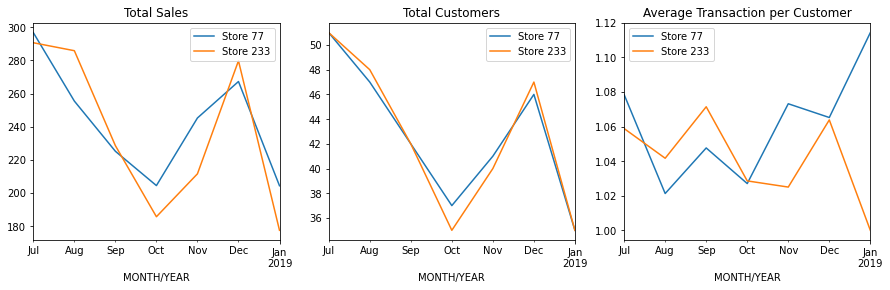

In [26]:
#Compare the performance of Store 77 and Store 233
fig, axes= plt.subplots(ncols = 3, nrows = 1,figsize = (15,4))

#Total Sales
axes[0].set_title('Total Sales')
Pre_Trial_info[(Pre_Trial_info['STORE_NBR'] == 77)].plot.line(x = 'MONTH/YEAR', y = 'TOT_SALES', ax = axes[0], label = 'Store 77')
Pre_Trial_info[(Pre_Trial_info['STORE_NBR'] == 233)].plot.line(x = 'MONTH/YEAR', y = 'TOT_SALES', ax = axes[0], label = 'Store 233')

#Total Customers
axes[1].set_title('Total Customers')
Pre_Trial_info[(Pre_Trial_info['STORE_NBR'] == 77)].plot.line(x = 'MONTH/YEAR', y = 'TOT_CUSTOMER', ax = axes[1], label = 'Store 77')
Pre_Trial_info[(Pre_Trial_info['STORE_NBR'] == 233)].plot.line(x = 'MONTH/YEAR', y = 'TOT_CUSTOMER', ax = axes[1], label = 'Store 233')

#Average Transaction per Customer
axes[2].set_title('Average Transaction per Customer')
Pre_Trial_info[(Pre_Trial_info['STORE_NBR'] == 77)].plot.line(x = 'MONTH/YEAR', y = 'AVG_TRANS_per_CUSTOMER', ax = axes[2], label = 'Store 77')
Pre_Trial_info[(Pre_Trial_info['STORE_NBR'] == 233)].plot.line(x = 'MONTH/YEAR', y = 'AVG_TRANS_per_CUSTOMER', ax = axes[2], label = 'Store 233')


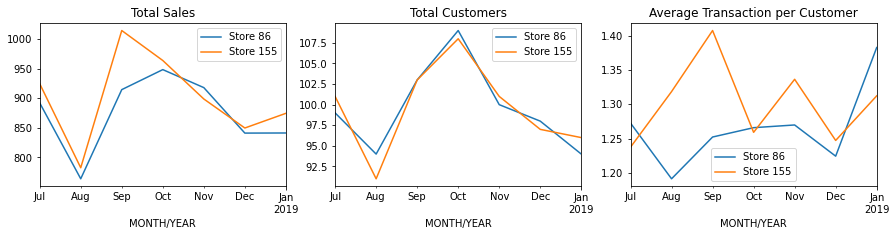

In [27]:
#Compare the performance of Store 86 and Store 155
fig, axes= plt.subplots(ncols = 3, nrows = 1,figsize = (15,3))

#Total Sales
axes[0].set_title('Total Sales')
Pre_Trial_info[(Pre_Trial_info['STORE_NBR'] == 86)].plot.line(x = 'MONTH/YEAR', y = 'TOT_SALES', ax = axes[0], label = 'Store 86')
Pre_Trial_info[(Pre_Trial_info['STORE_NBR'] == 155)].plot.line(x = 'MONTH/YEAR', y = 'TOT_SALES', ax = axes[0], label = 'Store 155')

#Total Customers
axes[1].set_title('Total Customers')
Pre_Trial_info[(Pre_Trial_info['STORE_NBR'] == 86)].plot.line(x = 'MONTH/YEAR', y = 'TOT_CUSTOMER', ax = axes[1], label = 'Store 86')
Pre_Trial_info[(Pre_Trial_info['STORE_NBR'] == 155)].plot.line(x = 'MONTH/YEAR', y = 'TOT_CUSTOMER', ax = axes[1], label = 'Store 155')

#Average Transaction per Customer
axes[2].set_title('Average Transaction per Customer')
Pre_Trial_info[(Pre_Trial_info['STORE_NBR'] == 86)].plot.line(x = 'MONTH/YEAR', y = 'AVG_TRANS_per_CUSTOMER', ax = axes[2], label = 'Store 86')
Pre_Trial_info[(Pre_Trial_info['STORE_NBR'] == 155)].plot.line(x = 'MONTH/YEAR', y = 'AVG_TRANS_per_CUSTOMER', ax = axes[2], label = 'Store 155')


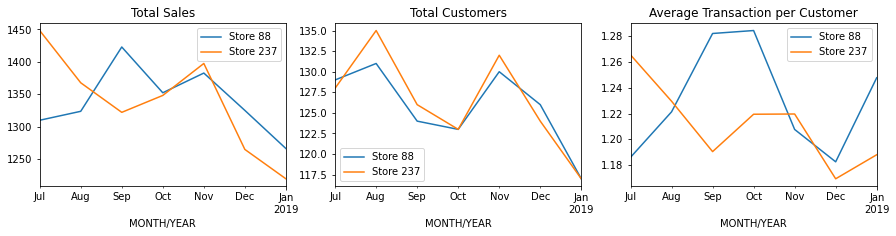

In [28]:
#Compare the performance of Store 88 and Store 237
fig, axes= plt.subplots(ncols = 3, nrows = 1,figsize = (15,3))

#Total Sales
axes[0].set_title('Total Sales')
Pre_Trial_info[(Pre_Trial_info['STORE_NBR'] == 88)].plot.line(x = 'MONTH/YEAR', y = 'TOT_SALES', ax = axes[0], label = 'Store 88')
Pre_Trial_info[(Pre_Trial_info['STORE_NBR'] == 237)].plot.line(x = 'MONTH/YEAR', y = 'TOT_SALES', ax = axes[0], label = 'Store 237')

#Total Customers
axes[1].set_title('Total Customers')
Pre_Trial_info[(Pre_Trial_info['STORE_NBR'] == 88)].plot.line(x = 'MONTH/YEAR', y = 'TOT_CUSTOMER', ax = axes[1], label = 'Store 88')
Pre_Trial_info[(Pre_Trial_info['STORE_NBR'] == 237)].plot.line(x = 'MONTH/YEAR', y = 'TOT_CUSTOMER', ax = axes[1], label = 'Store 237')

#Average Transaction per Customer
axes[2].set_title('Average Transaction per Customer')
Pre_Trial_info[(Pre_Trial_info['STORE_NBR'] == 88)].plot.line(x = 'MONTH/YEAR', y = 'AVG_TRANS_per_CUSTOMER', ax = axes[2], label = 'Store 88')
Pre_Trial_info[(Pre_Trial_info['STORE_NBR'] == 237)].plot.line(x = 'MONTH/YEAR', y = 'AVG_TRANS_per_CUSTOMER', ax = axes[2], label = 'Store 237')


## Step 2: Trial Period Comparison

In [29]:
# Get the record over the trial period
Trial = QVI_data[(QVI_data['DATE']>= '2019-02-01') & (QVI_data['DATE']< '2019-05-01')]

In [30]:
# Drop the non-trial and non-control stores 
Trial.drop(index = Trial[Trial['STORE_NBR'].apply(lambda s: s not in [77,86,88,155,233,237])].index, inplace = True)

C:\Users\Jeff Lau\OneDrive\Anaconda\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [31]:
#Record the trial stores and its control counterpart, for the control stores we assign itself for the calculation convenience
stores = {77: 233 , 86: 155, 88: 237, 233: 233, 155: 155, 237: 237}

In [32]:
control_store_NBR

[77, 86, 88]

In [33]:
#Record the total sale of these stores before the trial period
Pre_Trial_overall= Pre_Trial_info[Pre_Trial_info['STORE_NBR'].apply(lambda s: s in [77,86,88,155,233,237])].groupby(by = 'STORE_NBR').sum()
Pre_Trial_overall

,TOT_CUSTOMER,TOT_SALES,PROD_QTY,TOT_TRANSACTION,AVG_TRANS_per_CUSTOMER
STORE_NBR,,,,,
77,299,1699.00,484,317,7.427028
86,697,6119.85,1754,882,8.860167
88,880,9383.60,2147,1082,8.612327
155,697,6308.70,1805,908,9.119888
233,298,1659.80,478,311,7.289320
237,885,9369.00,2121,1073,8.482329


In [34]:
# Calculate the scaling factor of total sales over the pre-trial period for the pairs, and apply it on the total sales in trial stores over the trial period
# First we define the method for the scaling factor

def scaled_quantity(tri_nbr,FEATURE,df):
    control_nbr = stores[tri_nbr]
    s = Pre_Trial_overall.loc[control_nbr][FEATURE]/Pre_Trial_overall.loc[tri_nbr][FEATURE]
    return (df[df['STORE_NBR'] == tri_nbr][FEATURE] * s ).item()

In [35]:
#Apply the scaling factor into the new columns and recorded

#total sales
Trial_sum = Trial.groupby(by = 'STORE_NBR').sum()['TOT_SALES'].reset_index()
Trial_sum['Scaled_TOT_SALES'] = Trial_sum['STORE_NBR'].apply(scaled_quantity,FEATURE = 'TOT_SALES',df = Trial_sum)
Trial_sum['Scaled_TOT_SALES']= Trial_sum['Scaled_TOT_SALES'].round(2)

#total customer
Trial_count = Trial.groupby(by = 'STORE_NBR').nunique()['LYLTY_CARD_NBR'].reset_index()
Trial_count.rename(columns={'LYLTY_CARD_NBR':'TOT_CUSTOMER'}, inplace = True)
Trial_count['Scaled_TOT_CUSTOMER'] = Trial_count['STORE_NBR'].apply(scaled_quantity,FEATURE = 'TOT_CUSTOMER', df = Trial_count)
Trial_count['Scaled_TOT_CUSTOMER'] = Trial_count['Scaled_TOT_CUSTOMER'].apply(lambda s : int(s))

In [36]:
Trial_overall = pd.merge(Trial_sum, Trial_count).set_index("STORE_NBR")
Trial_overall

,TOT_SALES,Scaled_TOT_SALES,TOT_CUSTOMER,Scaled_TOT_CUSTOMER
STORE_NBR,,,,
77,777.0,759.07,124,123
86,2788.2,2874.24,215,215
88,4286.8,4280.13,261,262
155,2540.2,2540.20,190,190
233,601.7,601.70,112,112
237,3817.6,3817.60,262,262


In [37]:
#Display the percentage difference of total sales of each pair
percentd = {}

for num in control_store_NBR:
    percentd[(num, stores[num])] = (Trial_overall.loc[num]['Scaled_TOT_SALES'] - Trial_overall.loc[stores[num]]['Scaled_TOT_SALES'])/(Trial_overall.loc[stores[num]]['Scaled_TOT_SALES'])
    
percentd_data_0 = pd.DataFrame(percentd.items(), columns = ['Tri, Ctr','%_diff_TOT_SALES'])




In [38]:
#Display the percentage difference of total customers of each pair
for num in control_store_NBR:
    percentd[(num, stores[num])] = (Trial_overall.loc[num]['Scaled_TOT_CUSTOMER'] - Trial_overall.loc[stores[num]]['Scaled_TOT_CUSTOMER'])/(Trial_overall.loc[stores[num]]['Scaled_TOT_CUSTOMER'])

percentd_data_1 = pd.DataFrame(percentd.items(), columns = ['Tri, Ctr','%_diff_TOT_CUSTOMER'])


percentd_data = pd.merge(percentd_data_0,percentd_data_1)

In [39]:
percentd_data.set_index('Tri, Ctr',inplace = True)
percentd_data

,%_diff_TOT_SALES,%_diff_TOT_CUSTOMER
"Tri, Ctr",,
"(77, 233)",0.261542,0.098214
"(86, 155)",0.131501,0.131579
"(88, 237)",0.121157,0.000000
